In [17]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# MySQL connection config
config = {
    'user': 'root',
    'password': 'farah123',
    'host': 'localhost',
    'database': 'dw_schema',  
    'raise_on_warnings': True
}

In [4]:
def get_connection():
    """Get database connection"""
    try:
        conn = mysql.connector.connect(**config)
        return conn
    except mysql.connector.Error as e:
        print(f"Error connecting to database: {e}")
        return None

In [5]:
def execute_query(query):
    """Execute SQL query and return DataFrame"""
    conn = get_connection()
    if not conn:
        return pd.DataFrame()
    
    try:
        df = pd.read_sql(query, conn)
        return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return pd.DataFrame()
    finally:
        conn.close()

In [6]:
def show_summary_stats():
    """Show summary statistics of the data warehouse"""
    print("DATA WAREHOUSE SUMMARY")
    print("=" * 50)
    
    tables = ['dim_date', 'dim_staff', 'dim_rental', 'dim_film', 'dim_store', 
             'fact_monthly_payment', 'fact_daily_inventory']
    
    for table in tables:
        query = f"SELECT COUNT(*) as count FROM dw_schema.{table}"
        result = execute_query(query)
        count = result['count'].iloc[0] if not result.empty else 0
        print(f"{table:<20}: {count:,} records")

In [18]:
def visualize_monthly_revenue():
    """Visualize monthly revenue trends using matplotlib"""
    query = """
    SELECT 
        d.month_name,
        d.year,
        SUM(f.amount) as total_revenue,
        COUNT(f.payment_key) as payment_count,
        AVG(f.amount) as avg_payment
    FROM dw_schema.fact_monthly_payment f
    JOIN dw_schema.dim_date d ON f.date_key = d.date_key
    GROUP BY d.month_name, d.year, d.month
    ORDER BY d.year, d.month
    """
    
    df = execute_query(query)
    if df.empty:
        print("❌ No payment data found")
        return
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Monthly revenue
    ax1.bar(df['month_name'], df['total_revenue'], color='skyblue', alpha=0.8)
    ax1.set_title('💰 Monthly Revenue', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Revenue ($)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Payment count
    ax2.bar(df['month_name'], df['payment_count'], color='lightgreen', alpha=0.8)
    ax2.set_title('📊 Payment Count by Month', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Payment Count')
    ax2.tick_params(axis='x', rotation=45)
    
    # Average payment
    ax3.plot(df['month_name'], df['avg_payment'], marker='o', linewidth=2, markersize=8, color='orange')
    ax3.set_title('💵 Average Payment Value', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Average Payment ($)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Revenue trend line
    ax4.plot(df['month_name'], df['total_revenue'], marker='s', linewidth=3, markersize=8, color='red')
    ax4.set_title('📈 Revenue Trend', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Revenue ($)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Monthly Revenue Analysis Dashboard', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"💰 Total Revenue: ${df['total_revenue'].sum():,.2f}")
    print(f"📊 Total Payments: {df['payment_count'].sum():,}")
    
    return df

In [19]:
def visualize_staff_performance():
    """Visualize staff performance using matplotlib"""
    query = """
    SELECT 
        s.first_name,
        s.last_name,
        s.store_name,
        COUNT(f.payment_key) as transactions,
        SUM(f.amount) as revenue,
        AVG(f.amount) as avg_transaction
    FROM dw_schema.fact_monthly_payment f
    JOIN dw_schema.dim_staff s ON f.staff_key = s.staff_key
    GROUP BY s.staff_key, s.first_name, s.last_name, s.store_name
    ORDER BY revenue DESC
    """
    
    df = execute_query(query)
    if df.empty:
        print("❌ No staff data found")
        return
    
    df['full_name'] = df['first_name'] + ' ' + df['last_name']
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Revenue by staff
    ax1.barh(df['full_name'], df['revenue'], color='darkblue', alpha=0.7)
    ax1.set_title('💰 Revenue by Staff Member', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Revenue ($)')
    
    # Transaction count
    ax2.barh(df['full_name'], df['transactions'], color='darkgreen', alpha=0.7)
    ax2.set_title('📊 Transactions by Staff', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Number of Transactions')
    
    # Average transaction
    ax3.barh(df['full_name'], df['avg_transaction'], color='darkorange', alpha=0.7)
    ax3.set_title('💵 Average Transaction Value', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Average Transaction ($)')
    
    # Store performance
    store_data = df.groupby('store_name')['revenue'].sum().reset_index()
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(store_data)]
    ax4.bar(store_data['store_name'], store_data['revenue'], color=colors, alpha=0.8)
    ax4.set_title('🏪 Revenue by Store', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Store')
    ax4.set_ylabel('Revenue ($)')
    
    plt.suptitle('Staff Performance Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n👥 Staff Performance Summary:")
    print(df[['full_name', 'transactions', 'revenue', 'avg_transaction']].to_string(index=False))
    
    return df

In [20]:
def visualize_top_films():
    """Visualize top performing films using matplotlib"""
    query = """
    SELECT 
        f.title,
        f.category,
        f.rating,
        COUNT(r.rental_key) as rental_count
    FROM dw_schema.dim_film f
    LEFT JOIN dw_schema.dim_rental r ON f.title = r.film_title
    GROUP BY f.film_key, f.title, f.category, f.rating
    HAVING rental_count > 0
    ORDER BY rental_count DESC
    LIMIT 20
    """
    
    df = execute_query(query)
    if df.empty:
        print("❌ No film data found")
        return
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top 10 films
    top_10 = df.head(10)
    ax1.barh(top_10['title'], top_10['rental_count'], color='lightcoral', alpha=0.8)
    ax1.set_title('🎬 Top 10 Films by Rentals', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Rental Count')
    
    # Category analysis
    category_data = df.groupby('category')['rental_count'].sum().reset_index()
    ax2.bar(category_data['category'], category_data['rental_count'], color='lightblue', alpha=0.8)
    ax2.set_title('📊 Rentals by Category', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Rental Count')
    ax2.tick_params(axis='x', rotation=45)
    
    # Rating analysis
    rating_data = df.groupby('rating')['rental_count'].sum().reset_index()
    ax3.bar(rating_data['rating'], rating_data['rental_count'], color='lightgreen', alpha=0.8)
    ax3.set_title('⭐ Rentals by Rating', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Rental Count')
    
    # Category pie chart
    ax4.pie(category_data['rental_count'], labels=category_data['category'], autopct='%1.1f%%', startangle=90)
    ax4.set_title('🥧 Category Distribution', fontsize=14, fontweight='bold')
    
    plt.suptitle('Film Performance Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎬 Total Films: {len(df)}")
    print(f"📊 Total Rentals: {df['rental_count'].sum():,}")
    print(f"🏆 Most Popular: {df.iloc[0]['title']} ({df.iloc[0]['rental_count']} rentals)")
    
    return df

In [21]:
def visualize_inventory_trends():
    """Visualize inventory trends using matplotlib"""
    query = """
    SELECT 
        d.full_date,
        d.day_name,
        d.is_weekend,
        SUM(f.available_qty) as available,
        SUM(f.rented_qty) as rented
    FROM dw_schema.fact_daily_inventory f
    JOIN dw_schema.dim_date d ON f.date_key = d.date_key
    GROUP BY d.full_date, d.day_name, d.is_weekend
    ORDER BY d.full_date
    LIMIT 30
    """
    
    df = execute_query(query)
    if df.empty:
        print("❌ No inventory data found")
        return
    
    df['total_inventory'] = df['available'] + df['rented']
    df['utilization_rate'] = (df['rented'] / df['total_inventory'] * 100).round(2)
    
    # Create time series chart
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Inventory levels
    ax1.plot(df['full_date'], df['available'], marker='o', linewidth=2, label='Available', color='green')
    ax1.plot(df['full_date'], df['rented'], marker='s', linewidth=2, label='Rented', color='red')
    ax1.set_title('📦 Daily Inventory Levels', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Inventory Count')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Utilization rate
    ax2.bar(df['full_date'], df['utilization_rate'], alpha=0.7, color='orange')
    ax2.set_title('📈 Inventory Utilization Rate', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Utilization Rate (%)')
    ax2.set_xlabel('Date')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Weekend analysis
    weekend_stats = df.groupby('is_weekend').agg({
        'rented': 'mean',
        'utilization_rate': 'mean'
    }).reset_index()
    weekend_stats['day_type'] = weekend_stats['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})
    
    print("\n📅 Weekend vs Weekday Analysis:")
    print(weekend_stats[['day_type', 'rented', 'utilization_rate']])
    
    return df

In [22]:
def create_executive_summary():
    """Create executive summary with KPIs using matplotlib"""
    query = """
    SELECT 
        SUM(amount) as total_revenue,
        COUNT(payment_key) as total_transactions,
        AVG(amount) as avg_transaction,
        COUNT(DISTINCT staff_key) as active_staff
    FROM dw_schema.fact_monthly_payment
    """
    
    df = execute_query(query)
    if df.empty:
        print("❌ No data for executive summary")
        return
    
    # Print KPIs
    print("\n" + "="*50)
    print("🎯 EXECUTIVE SUMMARY")
    print("="*50)
    print(f"💰 Total Revenue: ${df['total_revenue'].iloc[0]:,.2f}")
    print(f"📊 Total Transactions: {df['total_transactions'].iloc[0]:,}")
    print(f"💵 Average Transaction: ${df['avg_transaction'].iloc[0]:.2f}")
    print(f"👥 Active Staff: {df['active_staff'].iloc[0]}")
    print("="*50)
    
    # Create KPI chart
    metrics = ['Revenue', 'Transactions', 'Avg Transaction', 'Staff']
    values = [
        df['total_revenue'].iloc[0],
        df['total_transactions'].iloc[0],
        df['avg_transaction'].iloc[0],
        df['active_staff'].iloc[0]
    ]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(metrics, values, color=colors, alpha=0.8)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.title('🎯 Key Performance Indicators', fontsize=16, fontweight='bold')
    plt.ylabel('Values')
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()
    
    return df

In [23]:
def visualize_payment_patterns():
    """Visualize payment patterns by day using matplotlib"""
    query = """
    SELECT 
        d.day_name,
        d.is_weekend,
        COUNT(f.payment_key) as payment_count,
        SUM(f.amount) as revenue,
        AVG(f.amount) as avg_payment
    FROM dw_schema.fact_monthly_payment f
    JOIN dw_schema.dim_date d ON f.date_key = d.date_key
    GROUP BY d.day_name, d.is_weekend
    ORDER BY 
        CASE d.day_name 
            WHEN 'Monday' THEN 1
            WHEN 'Tuesday' THEN 2
            WHEN 'Wednesday' THEN 3
            WHEN 'Thursday' THEN 4
            WHEN 'Friday' THEN 5
            WHEN 'Saturday' THEN 6
            WHEN 'Sunday' THEN 7
        END
    """
    
    df = execute_query(query)
    if df.empty:
        print("❌ No payment pattern data found")
        return
    
    # Create day-of-week analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Payments by day
    colors = ['lightblue' if x == 0 else 'lightcoral' for x in df['is_weekend']]
    ax1.bar(df['day_name'], df['payment_count'], color=colors, alpha=0.8)
    ax1.set_title('📅 Payments by Day of Week', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Payment Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Revenue by day
    ax2.bar(df['day_name'], df['revenue'], color=colors, alpha=0.8)
    ax2.set_title('💰 Revenue by Day of Week', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Revenue ($)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    best_day = df.loc[df['revenue'].idxmax()]
    worst_day = df.loc[df['revenue'].idxmin()]
    
    print(f"\n📈 Best Revenue Day: {best_day['day_name']} (${best_day['revenue']:,.2f})")
    print(f"📉 Lowest Revenue Day: {worst_day['day_name']} (${worst_day['revenue']:,.2f})")
    
    return df

In [13]:
def run_all_visualizations():
    """Run all visualization functions"""
    print("Starting Data Warehouse Visualization...")
    
    # Summary
    show_summary_stats()
    
    # Executive summary
    create_executive_summary()
    
    # Revenue analysis
    print("\n Creating revenue analysis...")
    visualize_monthly_revenue()
    
    # Staff performance
    print("\n Creating staff performance analysis...")
    visualize_staff_performance()
    
    # Film analysis
    print("\n Creating film analysis...")
    visualize_top_films()
    
    # Payment patterns
    print("\n Creating payment patterns...")
    visualize_payment_patterns()
    
    # Inventory trends
    print("\n Creating inventory analysis...")
    visualize_inventory_trends()
    
    print("\n All visualizations completed!")

In [14]:
def quick_dashboard():
    """Quick dashboard with key metrics"""
    print("Quick Dashboard")
    show_summary_stats()
    create_executive_summary()
    visualize_monthly_revenue()

Starting Data Warehouse Visualization...
DATA WAREHOUSE SUMMARY
dim_date            : 7,670 records
dim_staff           : 2 records
dim_rental          : 16,044 records
dim_film            : 1,000 records
dim_store           : 2 records
fact_monthly_payment: 16,044 records
fact_daily_inventory: 555,165 records

🎯 EXECUTIVE SUMMARY
💰 Total Revenue: $67,406.56
📊 Total Transactions: 16,044
💵 Average Transaction: $4.20
👥 Active Staff: 2


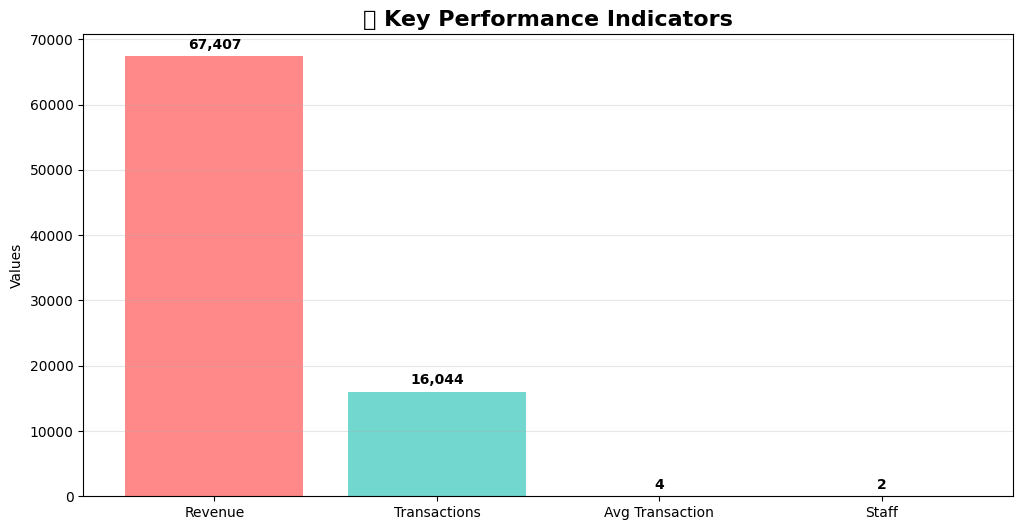


 Creating revenue analysis...


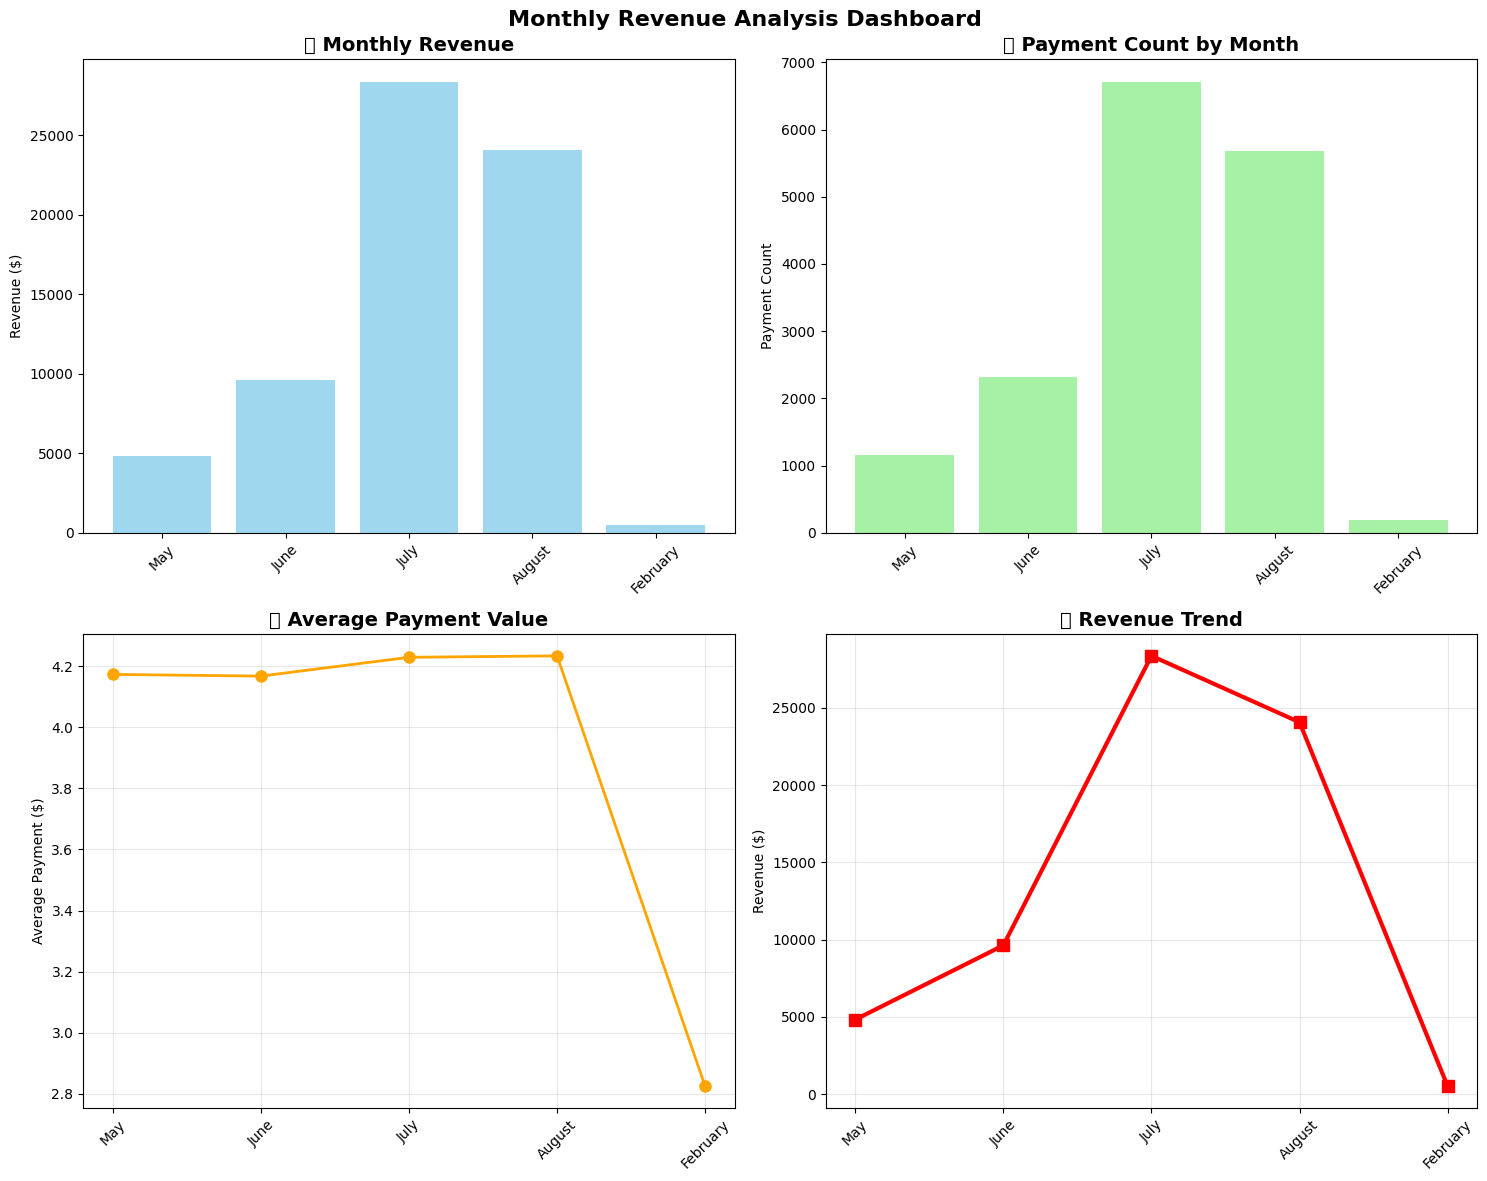

💰 Total Revenue: $67,406.56
📊 Total Payments: 16,044

 Creating staff performance analysis...


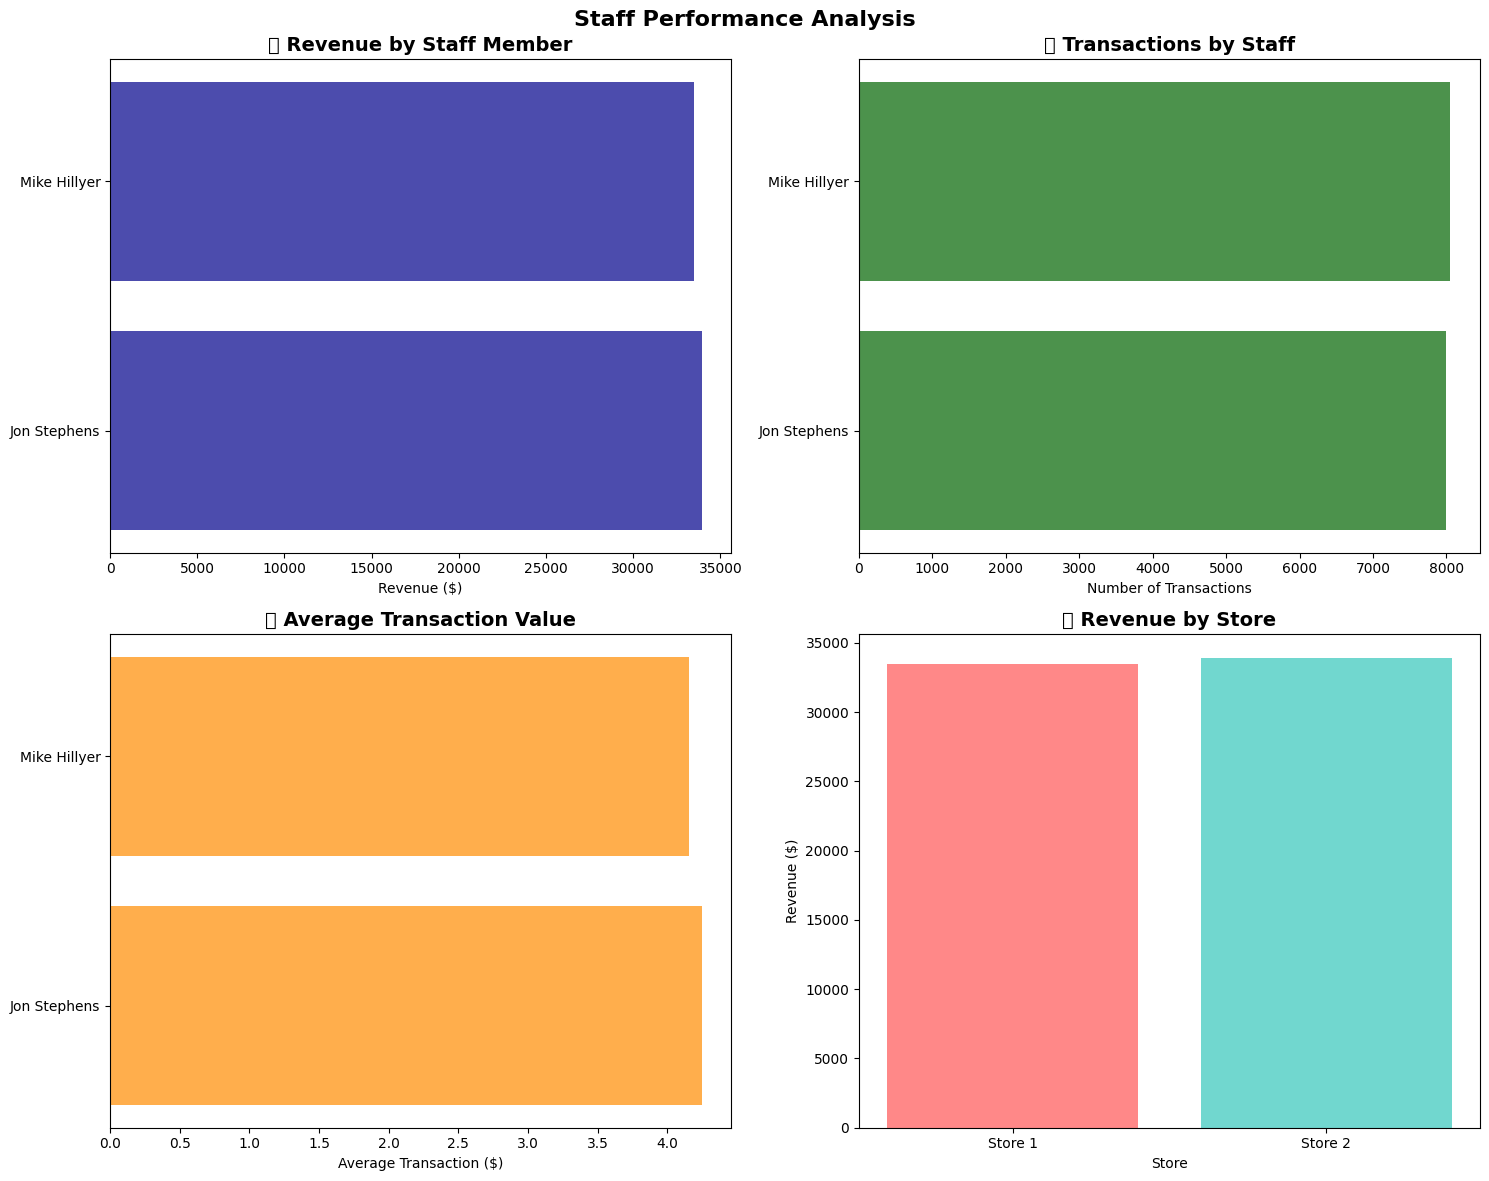


👥 Staff Performance Summary:
   full_name  transactions  revenue  avg_transaction
Jon Stephens          7990 33924.06         4.245815
Mike Hillyer          8054 33482.50         4.157251

 Creating film analysis...


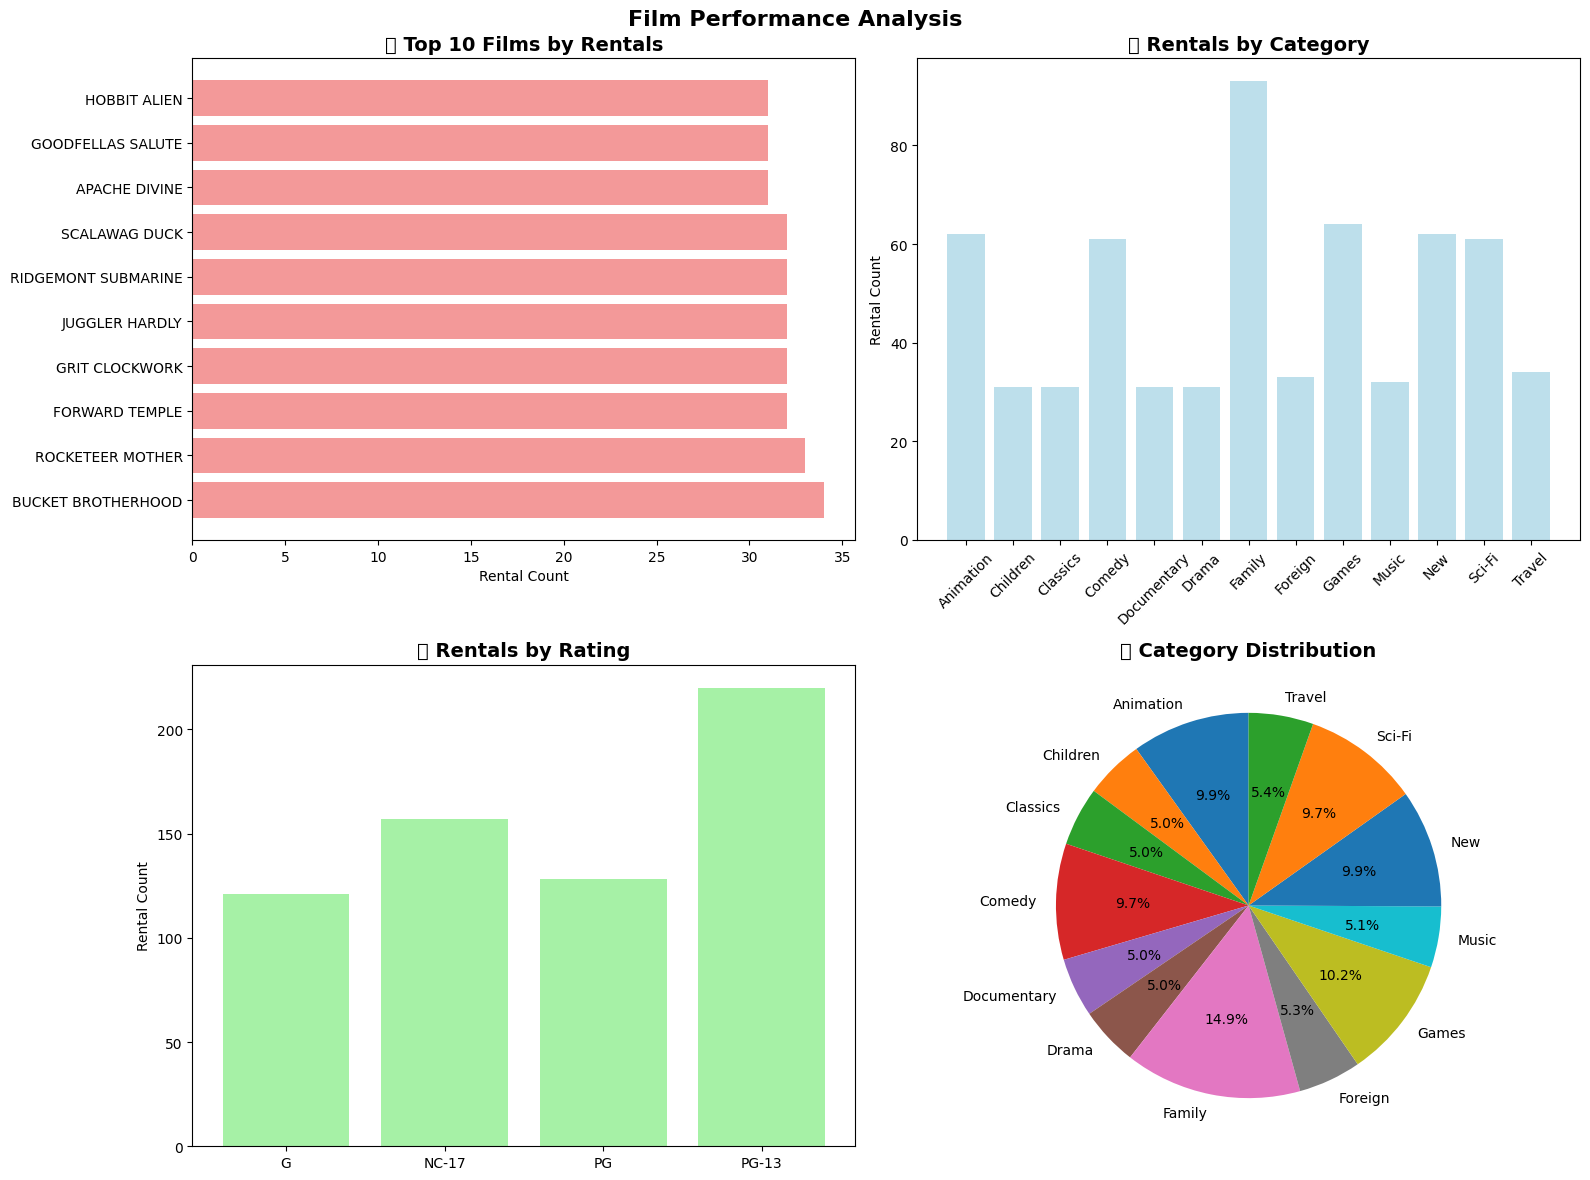


🎬 Total Films: 20
📊 Total Rentals: 626
🏆 Most Popular: BUCKET BROTHERHOOD (34 rentals)

 Creating payment patterns...


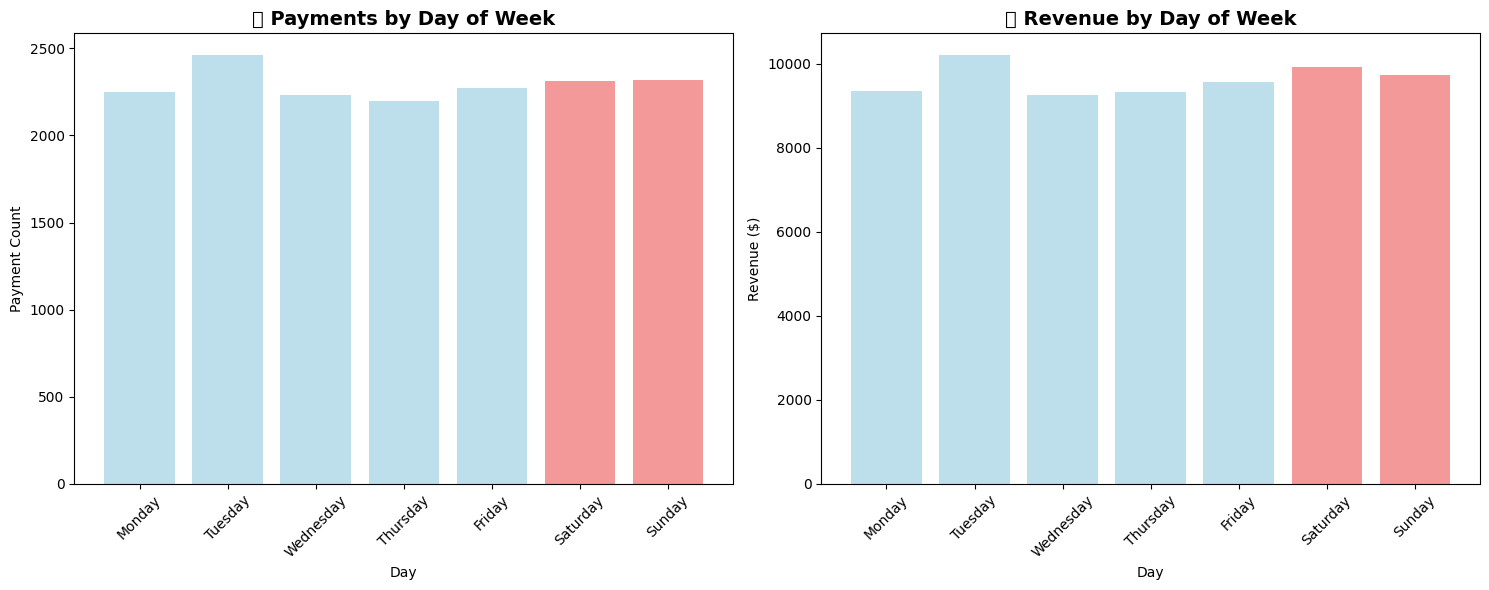


📈 Best Revenue Day: Tuesday ($10,217.37)
📉 Lowest Revenue Day: Wednesday ($9,265.69)

 Creating inventory analysis...


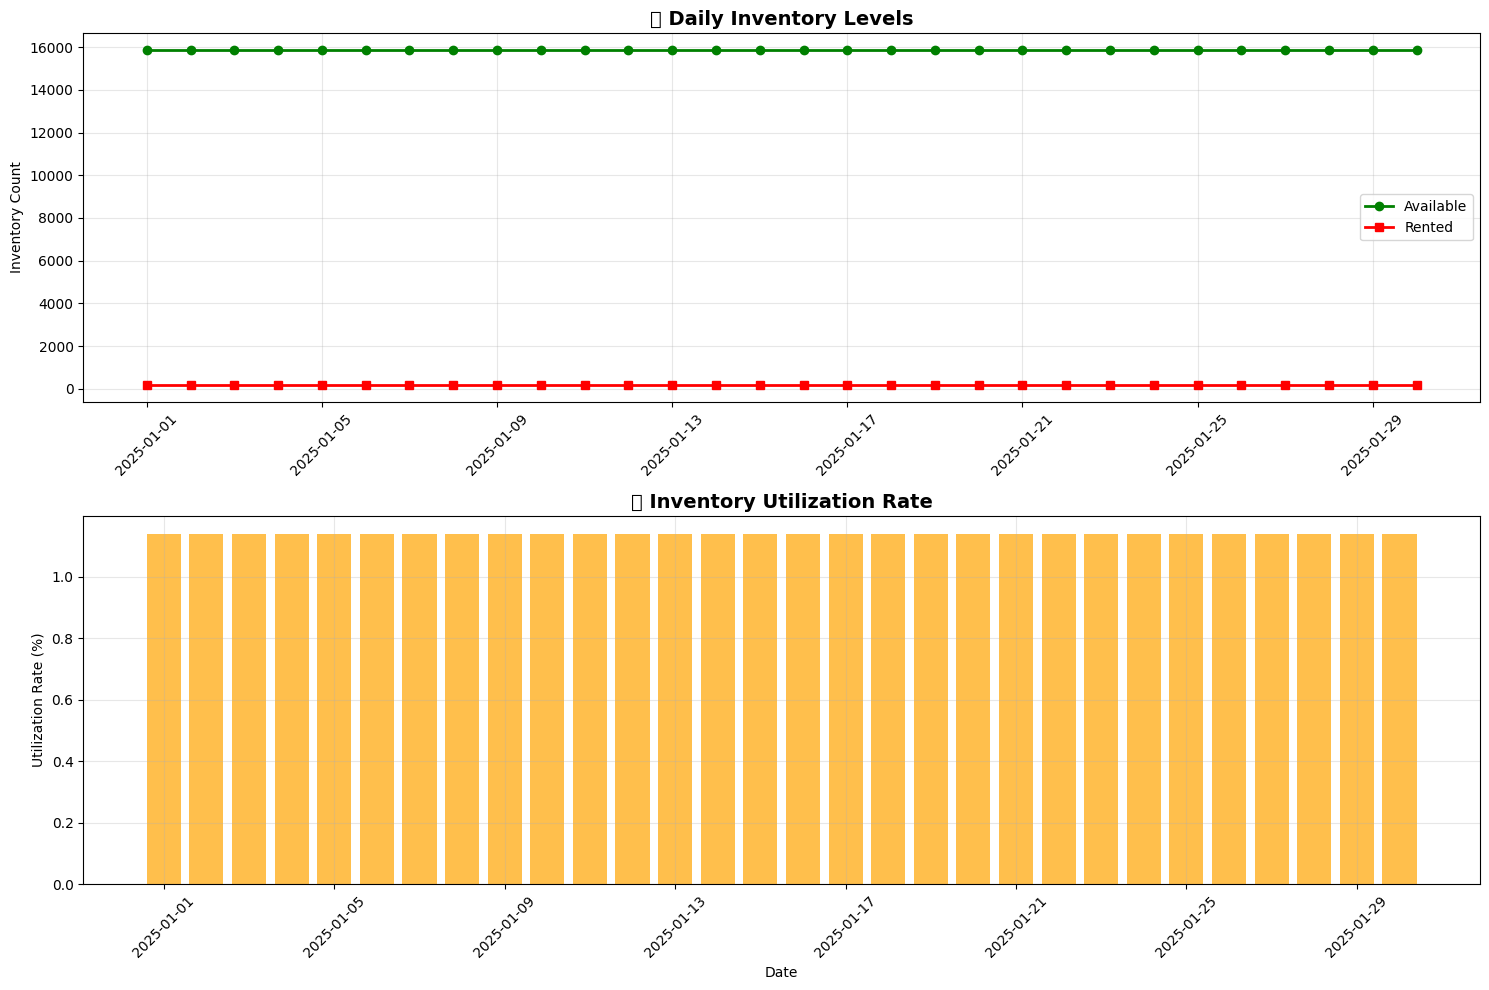


📅 Weekend vs Weekday Analysis:
  day_type  rented  utilization_rate
0  Weekday   183.0              1.14
1  Weekend   183.0              1.14

 All visualizations completed!


In [24]:
run_all_visualizations()